In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
pd.set_option('display.max_columns', None)

import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


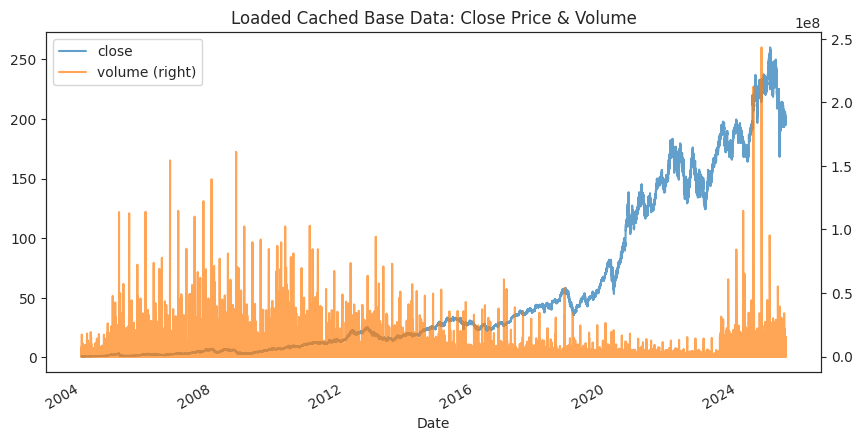

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764857    0.763714  
2004-01-02 09:01:00     28000.0    0.764857    0.763714  
2004-01-02 09:02:00     28000.0    0.764857    0.763714  
2004-01-02 09:03:00     28000.0    0.764857    0.763714  
2004-01-02 09:04:00     28000.0    0.764857    0.763714  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.962600  196.667400  
2025-06-18 20:57:00    460630.0  196.822500  196.527500  
2025-06-18 20:58:00    525245.0  196.817500  196.522500  
2025-06-18 20:59:00   2075503.0  196.387200  196.092800  
2025-06-18 21:00:00  15600625.0  196.687400  196.392600  

[3893400 rows x 7 columns]

In [2]:
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidasktoclose_pct   = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
def process_single_day(day_str: str, best_optuna_params: dict):
    """
    Process and plot a single trading session using a given set of hyperparameters.

    Returns:
      Tuple[pd.DataFrame, Dict] | None
        If a valid backtest runs, returns (df_day, perf_day).
        If no data or no trades, returns None.
    """
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    # Extract that day’s full-minute bars from the master df
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    print("\n Running trading pipeline on selected date …")
    # Call run_trading_pipeline with your per-day slice + EXACTLY the same best_optuna_params
    result = trades.run_trading_pipeline(
                                        df                       = day_df,
                                        col_signal               = 'signal', # name for the signal column to use
                                        col_action               = 'signal_action', # name for the trade-action column to add
                                        day_to_check             = day_str,
                                        **best_optuna_params            # unpack tuned parameters here
    )
    if result is None:
        print(" no trades found; skipping.")
        return

    # Unpack pipeline output: (df_signals, trades_list, performance_stats)
    df_day, trades_day, perf_day = result

    # Plot the equity & trade markers
    plots.plot_trades(
                    df                 = df_day,
                    col_signal1        = 'signal',
                    col_signal2        = False,
                    col_action         = 'signal_action',
                    trades             = trades_day,
                    buy_threshold      = best_optuna_params['buy_threshold'],
                    performance_stats  = perf_day,
                    start_plot         = params.sess_start # or sess_premark 
    )

    # Print the per-day summary
    print(f"\n* Performance for {day_dt.date()} *")
    for k, v in perf_day.items():
        print(f"  {k}: {v}")

    return df_day, perf_day


In [4]:
def saveDF_checkDAY(df: pd.DataFrame, best_optuna_params: dict):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals,
    using the supplied hyperparameters.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day(..., best_optuna_params)
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)

      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
            with **best_optuna_params
          – compute & print the full‐period summary
          – plot full‐period performance
          – isolate & compute the test‐period summary
          – plot test‐period performance
          – save the dataframe with the calculated signal
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open","high","low","close",
        "volume","bid","ask",
        "StrategyEarning","EarningDiff",
        "signal","signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
                df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
                  .index.normalize()
                  .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        # Pass best_optuna_params into process_single_day
        res = process_single_day(day_str = str(day.date()), 
                                 best_optuna_params = best_optuna_params)
        
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    # If we aren’t saving a full-run CSV, bail out
    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    # Unpack best_optuna_params into run_trading_pipeline exactly as in Optuna
    full_sim_results = trades.run_trading_pipeline(
                                                    df            = df,
                                                    col_signal    = 'signal',
                                                    col_action    = 'signal_action',
                                                    **best_optuna_params
    )

    # 1) Build combined DF & perf list (zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    # 2) Print & plot full‐period performance using df_all
    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # 3) Test‐period slice & plot
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all


best_optuna_value: 0.569932962962963
best_optuna_params: {'min_prof_thr': 0.010861687379938987, 'max_down_prop': 0.32253092752699497, 'gain_tightening_factor': 3.9456937810258235, 'merging_retracement_thr': 0.5304414794243472, 'merging_time_gap_thr': 2.0890119238154257, 'pre_entry_decay': 0.06008145127762534, 'short_penal_decay': 5.876284868163993, 'trailing_stop_pct': 0.04218805805869556, 'buy_threshold': 0.3826079127049577, 'top_percentile': 3.1842923339028144, 'smoothing_window': 5}

Month mode: processing 2023-09

=== Processing trading day 2023-09-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


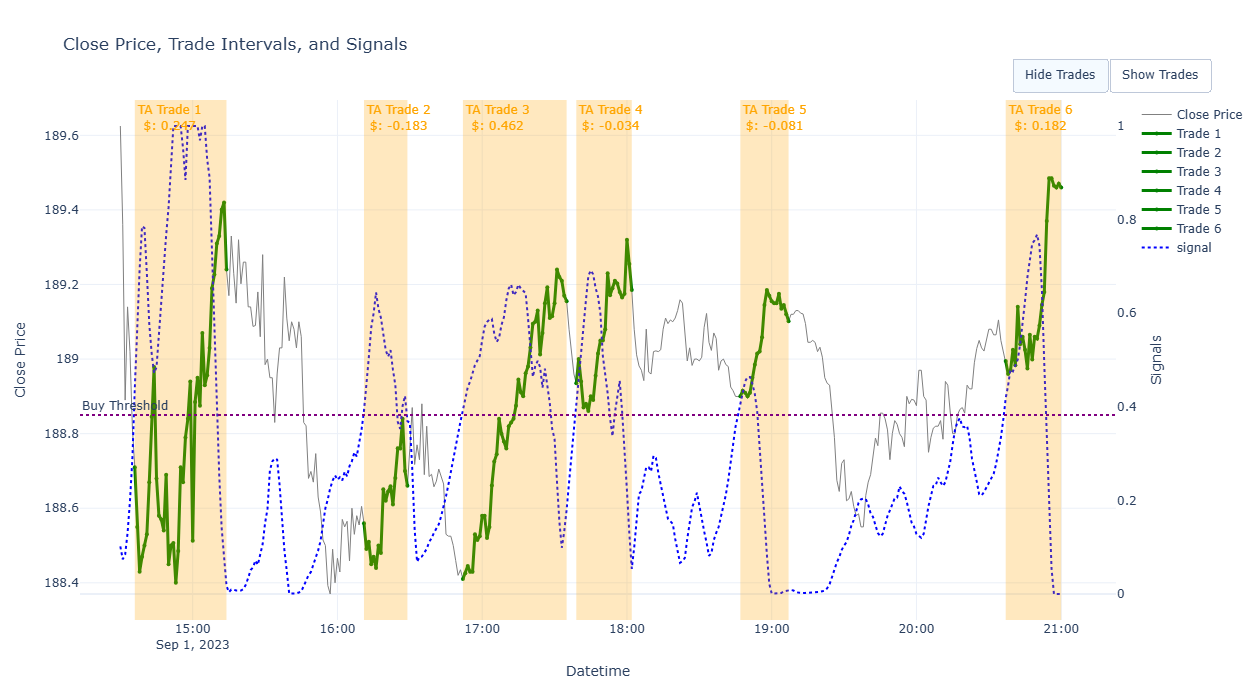


* Performance for 2023-09-01 *
  Buy & Hold Return ($): -0.449
  Strategy Return ($): 0.591
  Trades Returns ($): [0.247, -0.183, 0.462, -0.034, -0.081, 0.182]

=== Processing trading day 2023-09-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


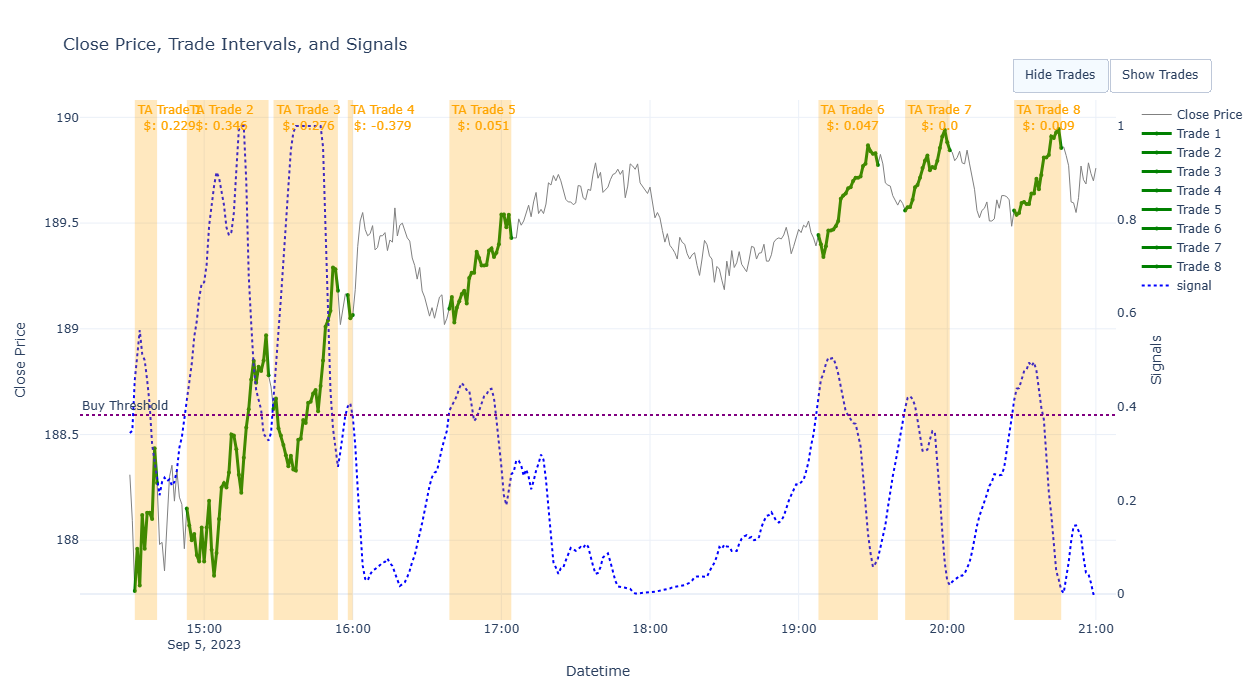


* Performance for 2023-09-05 *
  Buy & Hold Return ($): 1.167
  Strategy Return ($): 0.582
  Trades Returns ($): [0.229, 0.346, 0.276, -0.379, 0.051, 0.047, 0.0, 0.009]

=== Processing trading day 2023-09-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


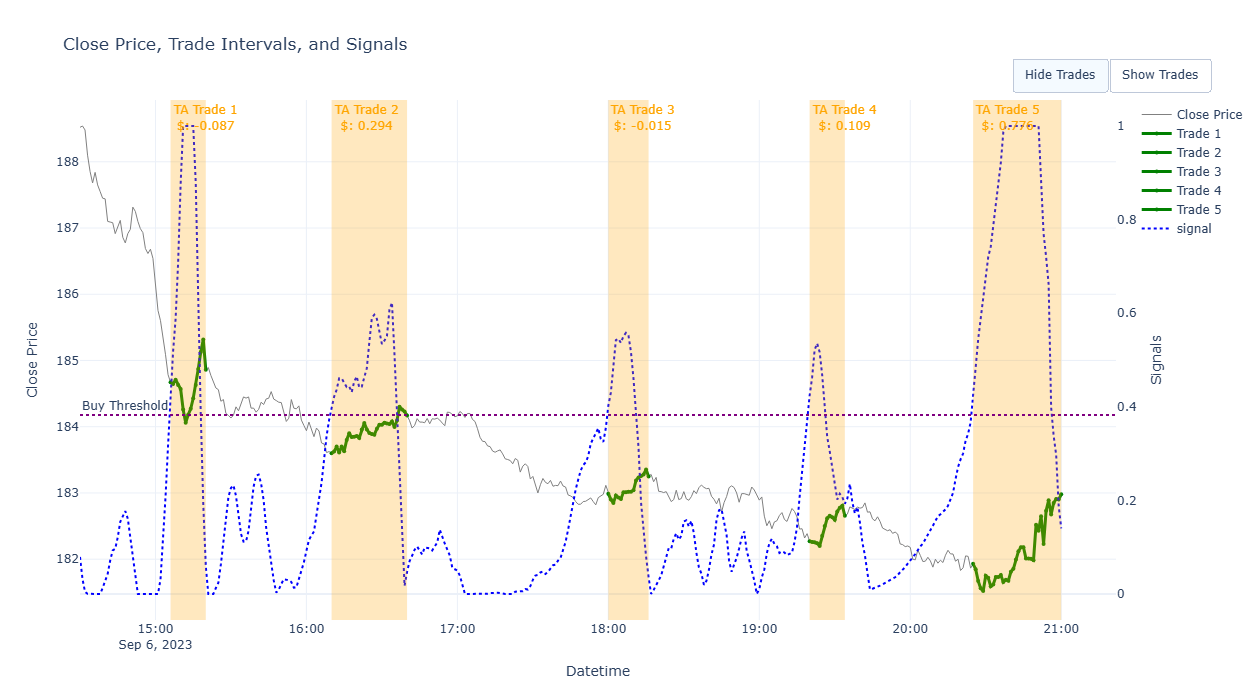


* Performance for 2023-09-06 *
  Buy & Hold Return ($): -5.819
  Strategy Return ($): 1.079
  Trades Returns ($): [-0.087, 0.294, -0.015, 0.109, 0.776]

=== Processing trading day 2023-09-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


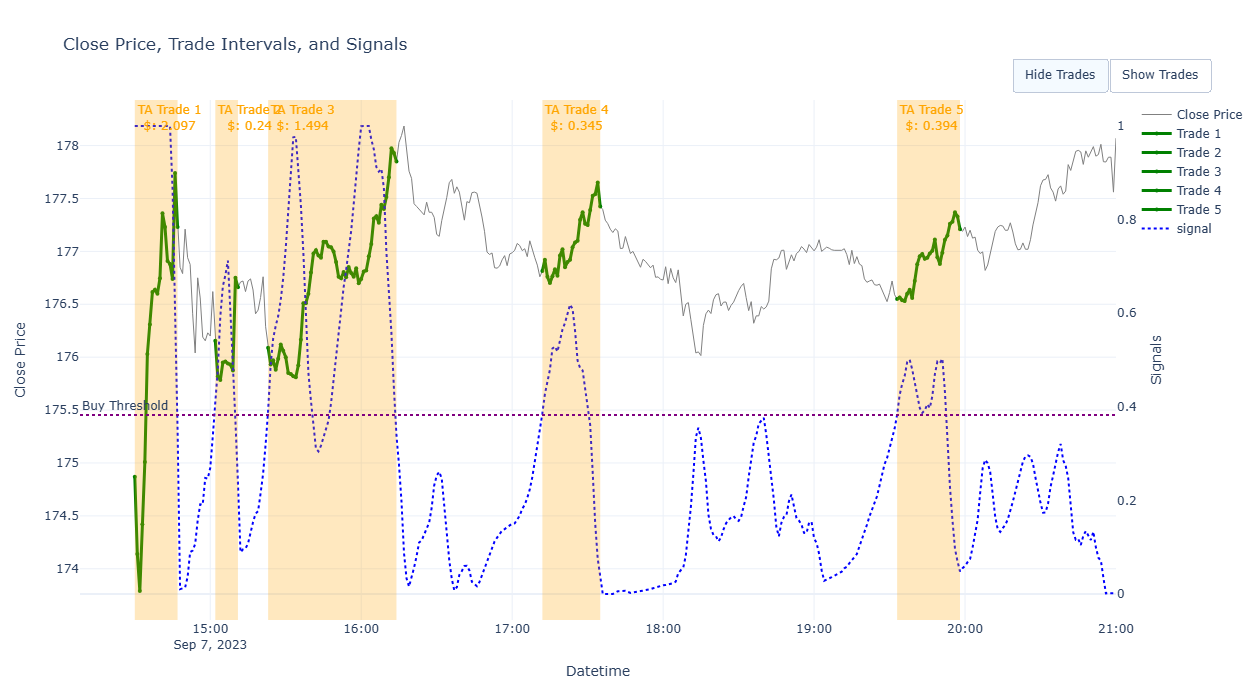


* Performance for 2023-09-07 *
  Buy & Hold Return ($): 2.935
  Strategy Return ($): 4.57
  Trades Returns ($): [2.097, 0.24, 1.494, 0.345, 0.394]

=== Processing trading day 2023-09-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


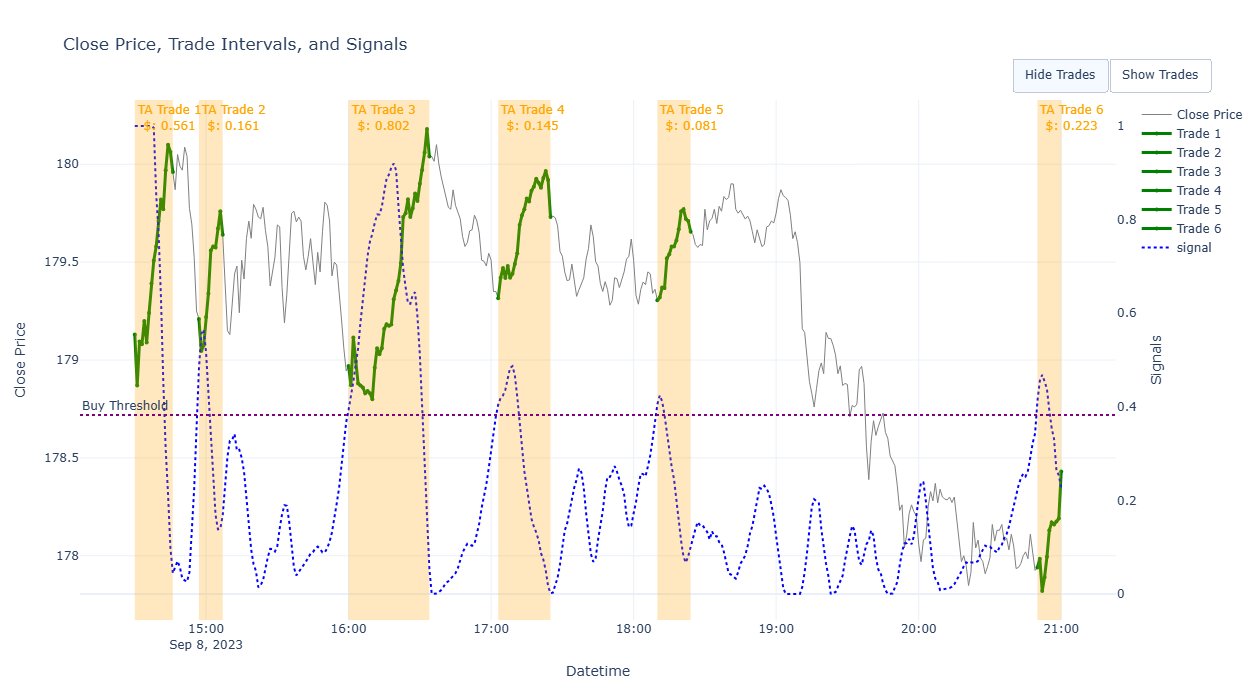


* Performance for 2023-09-08 *
  Buy & Hold Return ($): -0.968
  Strategy Return ($): 1.974
  Trades Returns ($): [0.561, 0.161, 0.802, 0.145, 0.081, 0.223]

=== Processing trading day 2023-09-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


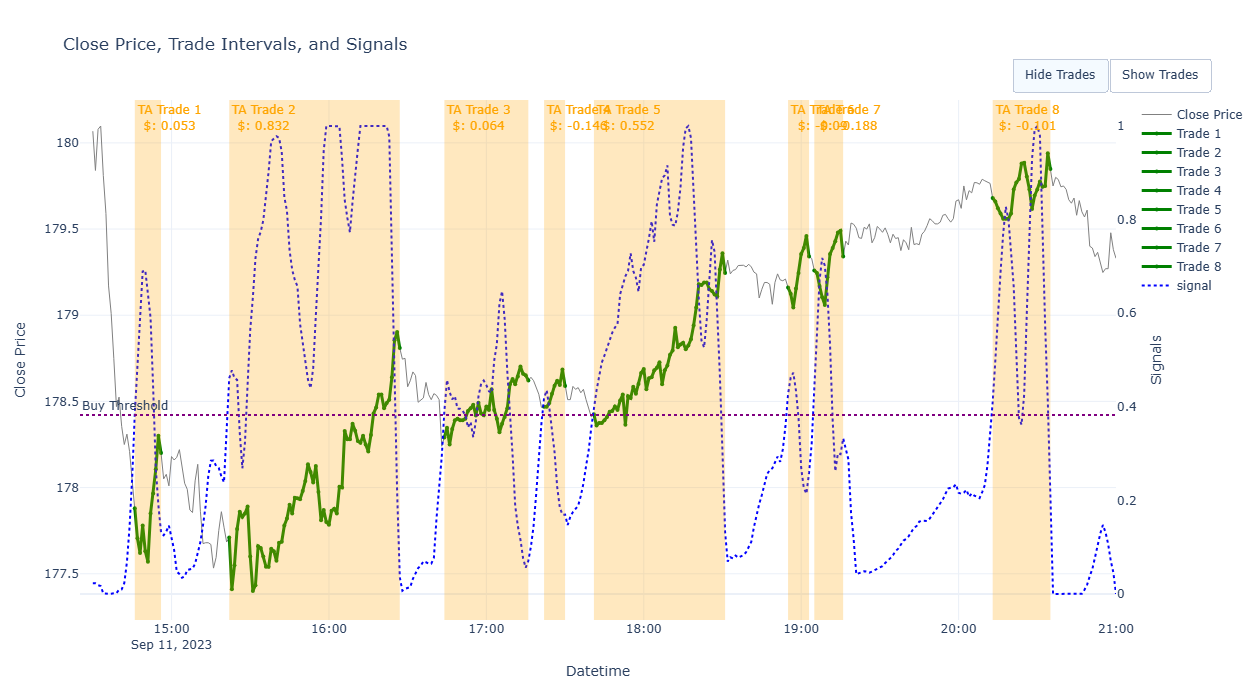


* Performance for 2023-09-11 *
  Buy & Hold Return ($): -1.007
  Strategy Return ($): 0.974
  Trades Returns ($): [0.053, 0.832, 0.064, -0.146, 0.552, -0.09, -0.188, -0.101]

=== Processing trading day 2023-09-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


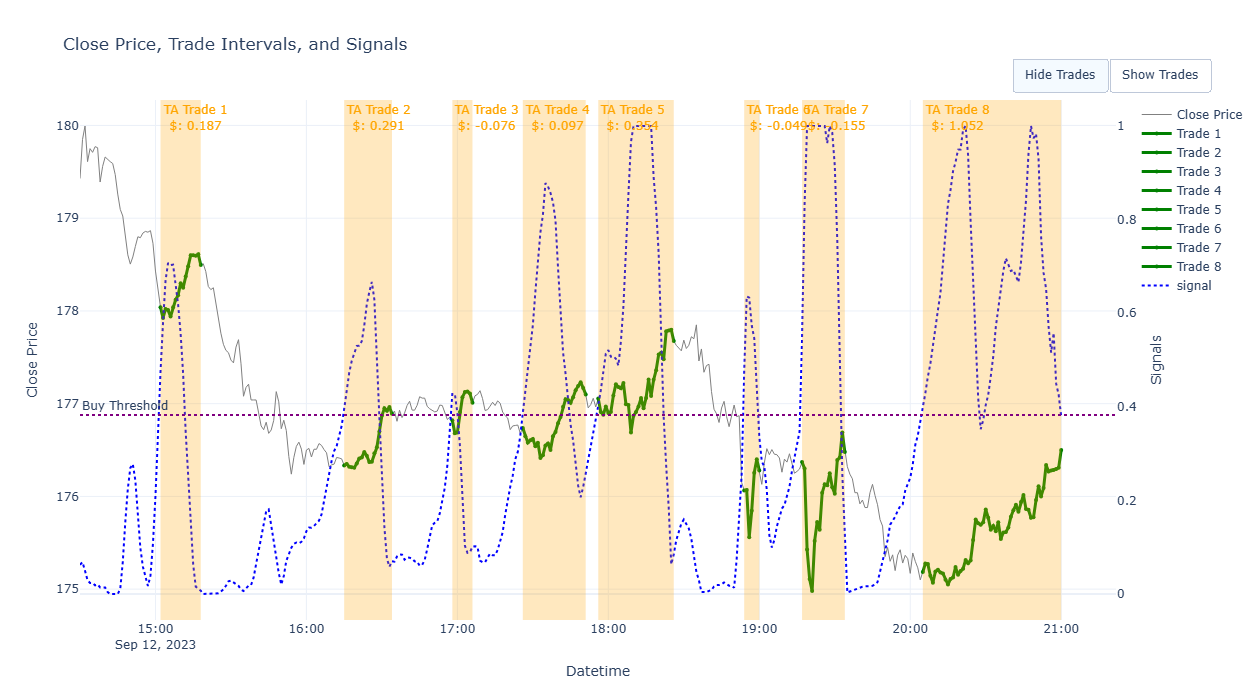


* Performance for 2023-09-12 *
  Buy & Hold Return ($): -3.195
  Strategy Return ($): 1.699
  Trades Returns ($): [0.187, 0.291, -0.076, 0.097, 0.354, -0.049, -0.155, 1.052]

=== Processing trading day 2023-09-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


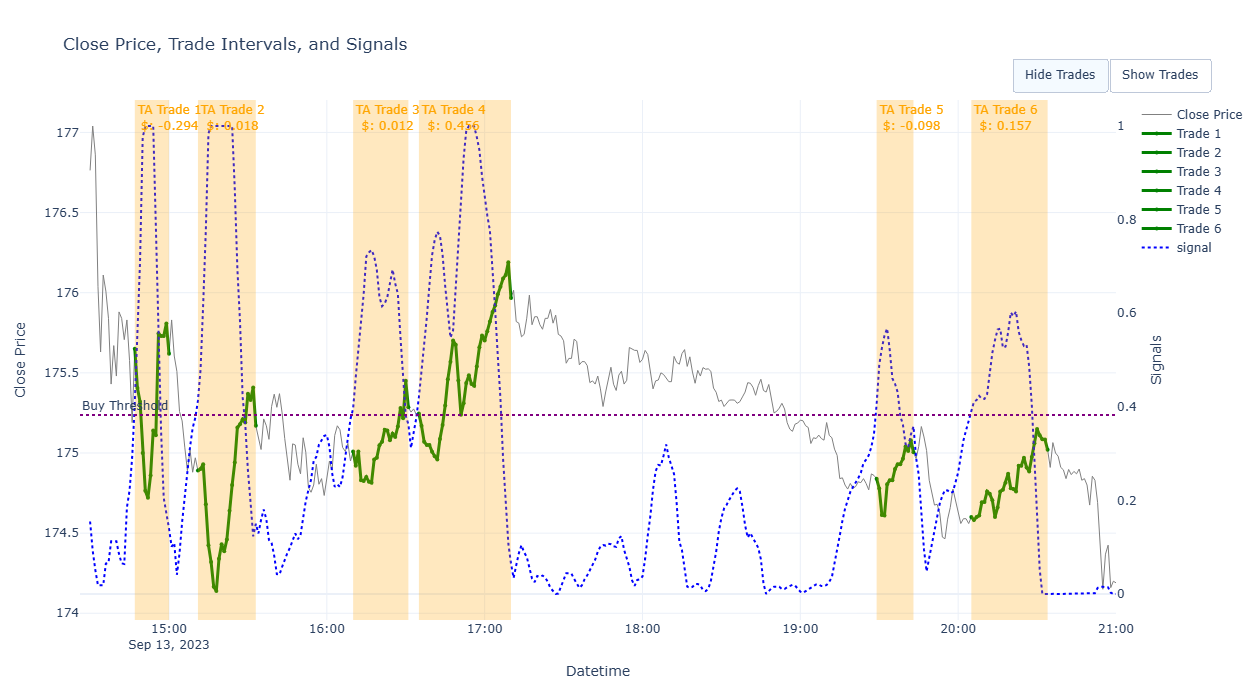


* Performance for 2023-09-13 *
  Buy & Hold Return ($): -2.836
  Strategy Return ($): 0.252
  Trades Returns ($): [-0.294, 0.018, 0.012, 0.456, -0.098, 0.157]

=== Processing trading day 2023-09-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


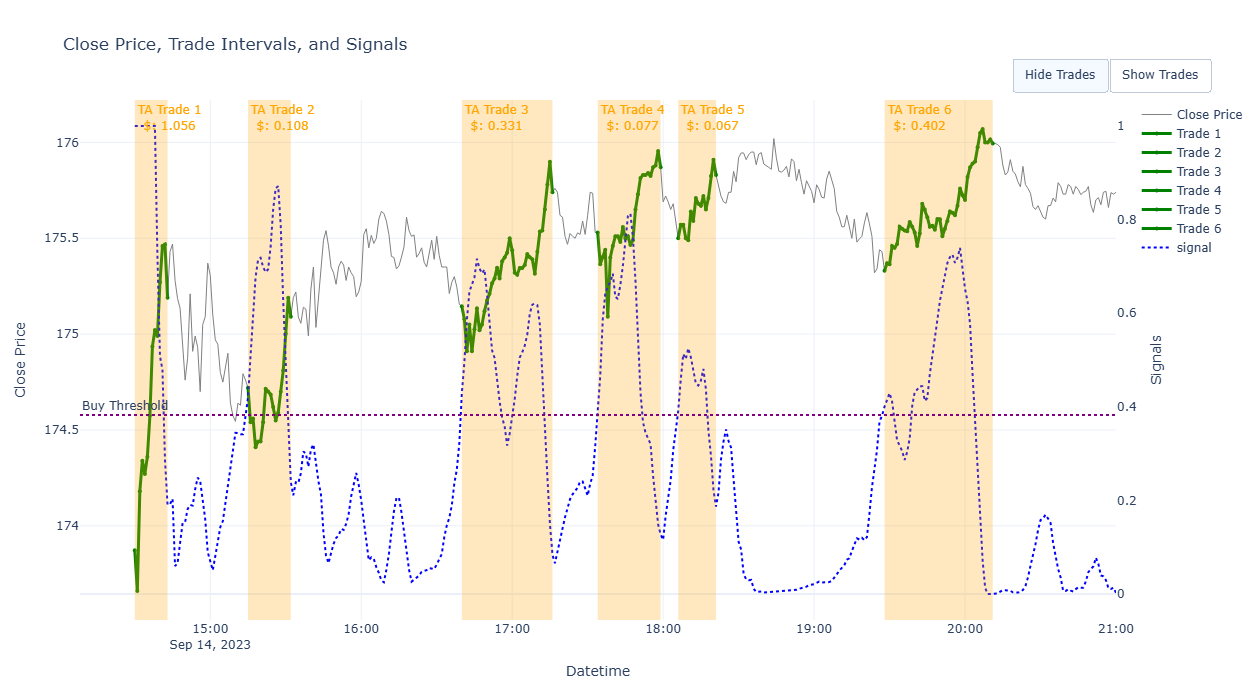


* Performance for 2023-09-14 *
  Buy & Hold Return ($): 1.605
  Strategy Return ($): 2.04
  Trades Returns ($): [1.056, 0.108, 0.331, 0.077, 0.067, 0.402]

=== Processing trading day 2023-09-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


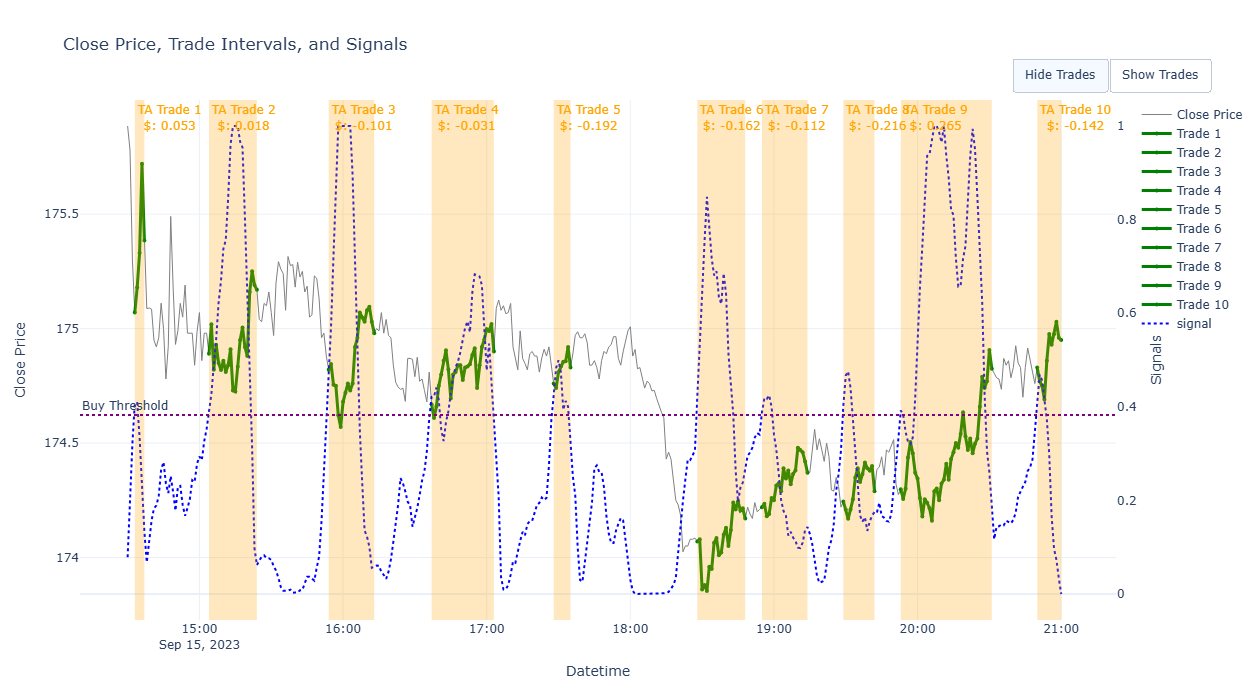


* Performance for 2023-09-15 *
  Buy & Hold Return ($): -1.198
  Strategy Return ($): -0.623
  Trades Returns ($): [0.053, 0.018, -0.101, -0.031, -0.192, -0.162, -0.112, -0.216, 0.265, -0.142]

=== Processing trading day 2023-09-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


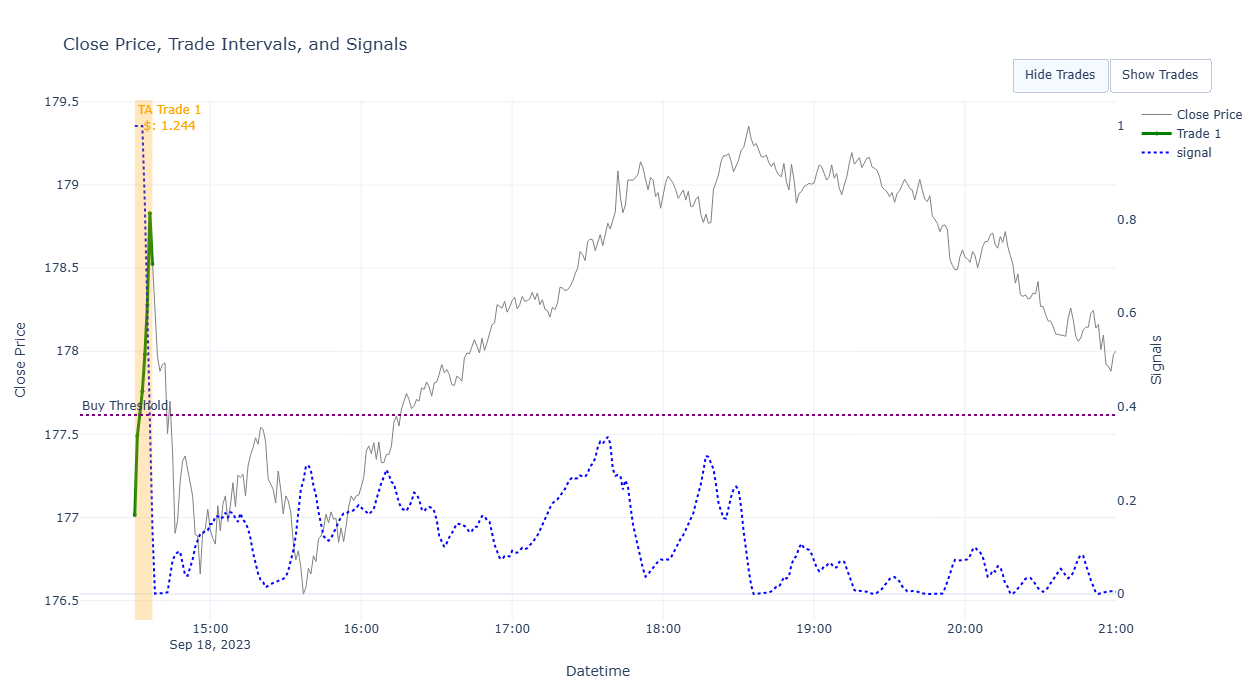


* Performance for 2023-09-18 *
  Buy & Hold Return ($): 0.72
  Strategy Return ($): 1.244
  Trades Returns ($): [1.244]

=== Processing trading day 2023-09-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


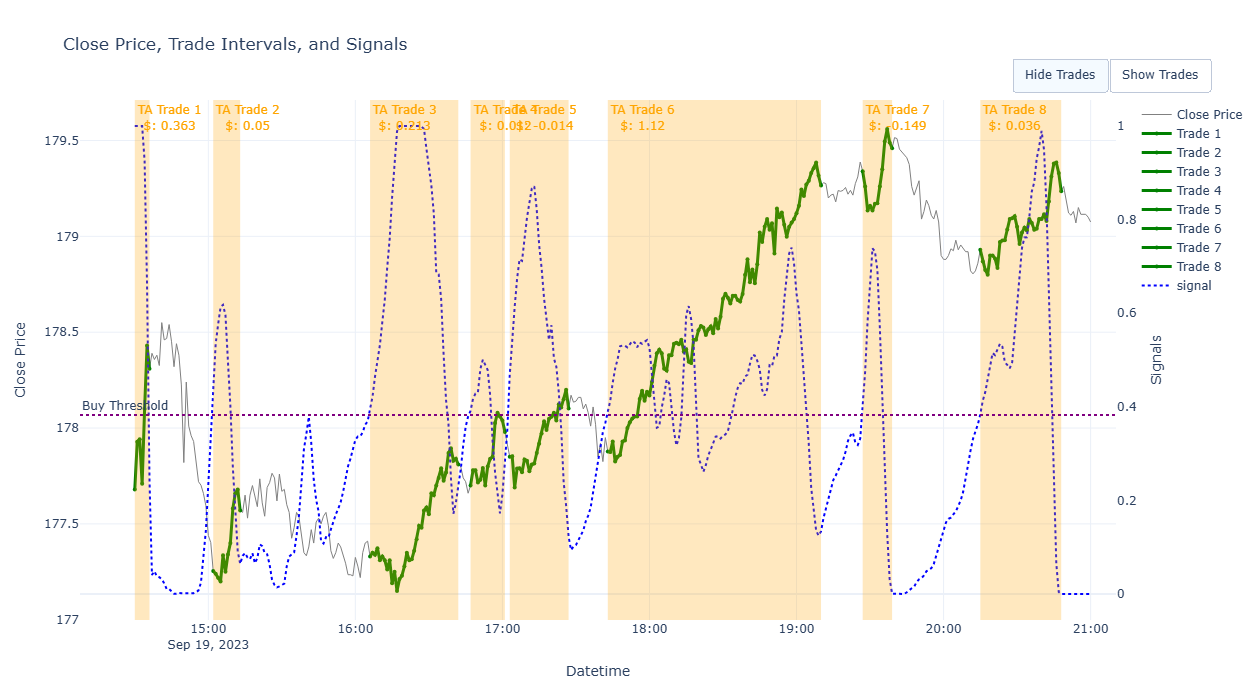


* Performance for 2023-09-19 *
  Buy & Hold Return ($): 1.127
  Strategy Return ($): 1.631
  Trades Returns ($): [0.363, 0.05, 0.213, 0.012, -0.014, 1.12, -0.149, 0.036]

=== Processing trading day 2023-09-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


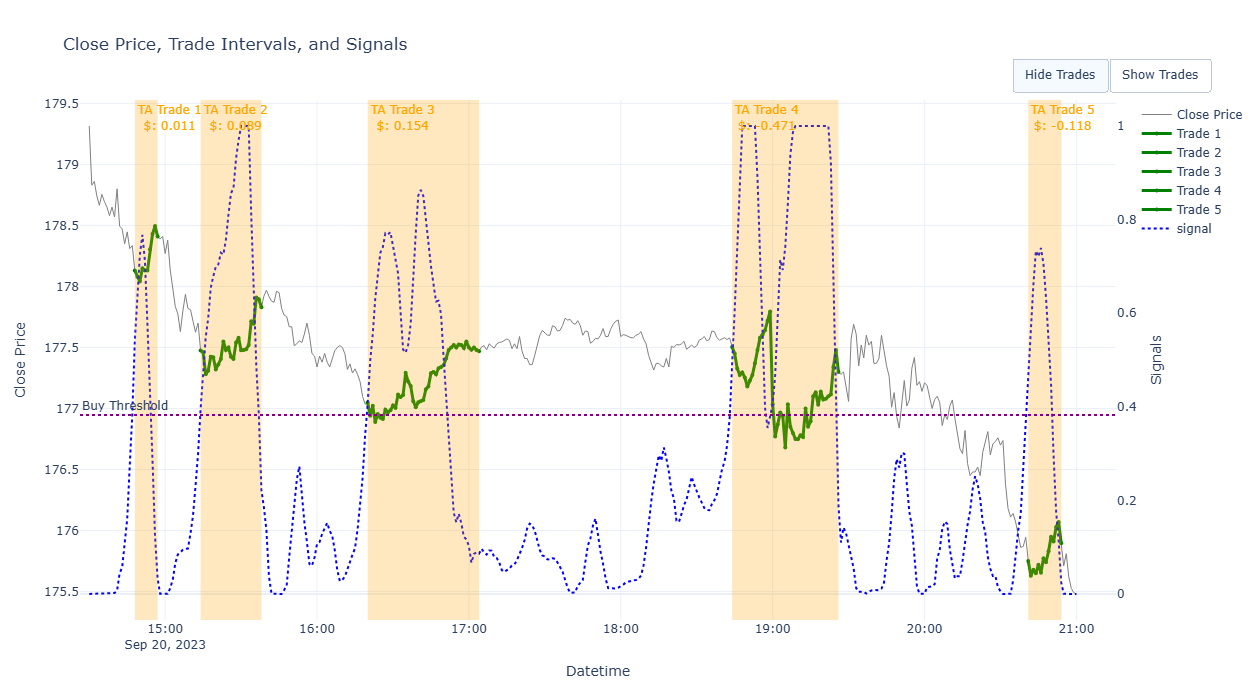


* Performance for 2023-09-20 *
  Buy & Hold Return ($): -4.101
  Strategy Return ($): -0.336
  Trades Returns ($): [0.011, 0.089, 0.154, -0.471, -0.118]

=== Processing trading day 2023-09-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


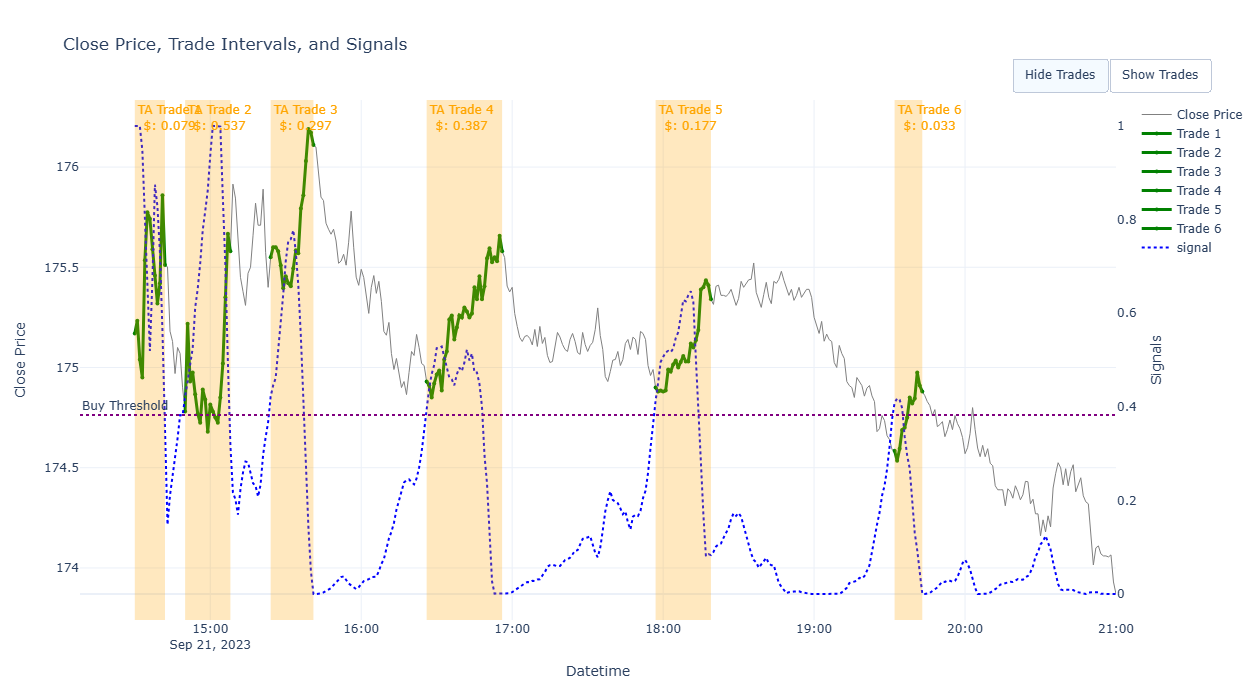


* Performance for 2023-09-21 *
  Buy & Hold Return ($): -1.562
  Strategy Return ($): 1.509
  Trades Returns ($): [0.079, 0.537, 0.297, 0.387, 0.177, 0.033]

=== Processing trading day 2023-09-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


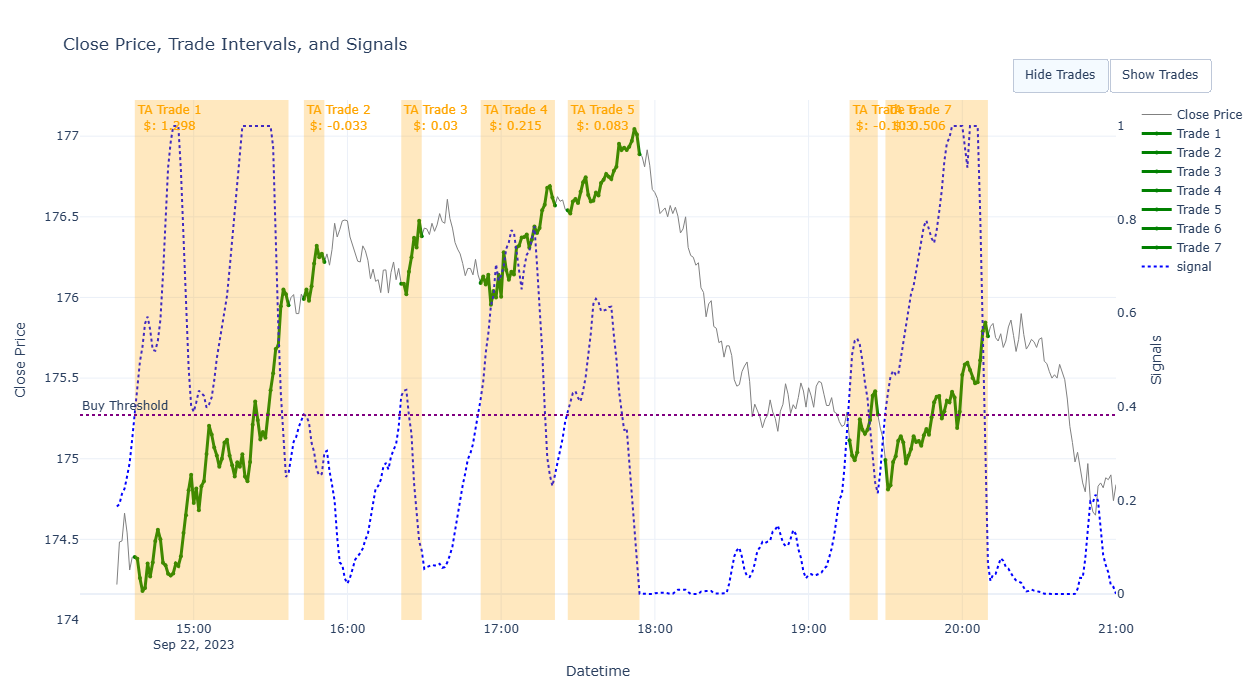


* Performance for 2023-09-22 *
  Buy & Hold Return ($): 0.358
  Strategy Return ($): 1.996
  Trades Returns ($): [1.298, -0.033, 0.03, 0.215, 0.083, -0.103, 0.506]

=== Processing trading day 2023-09-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


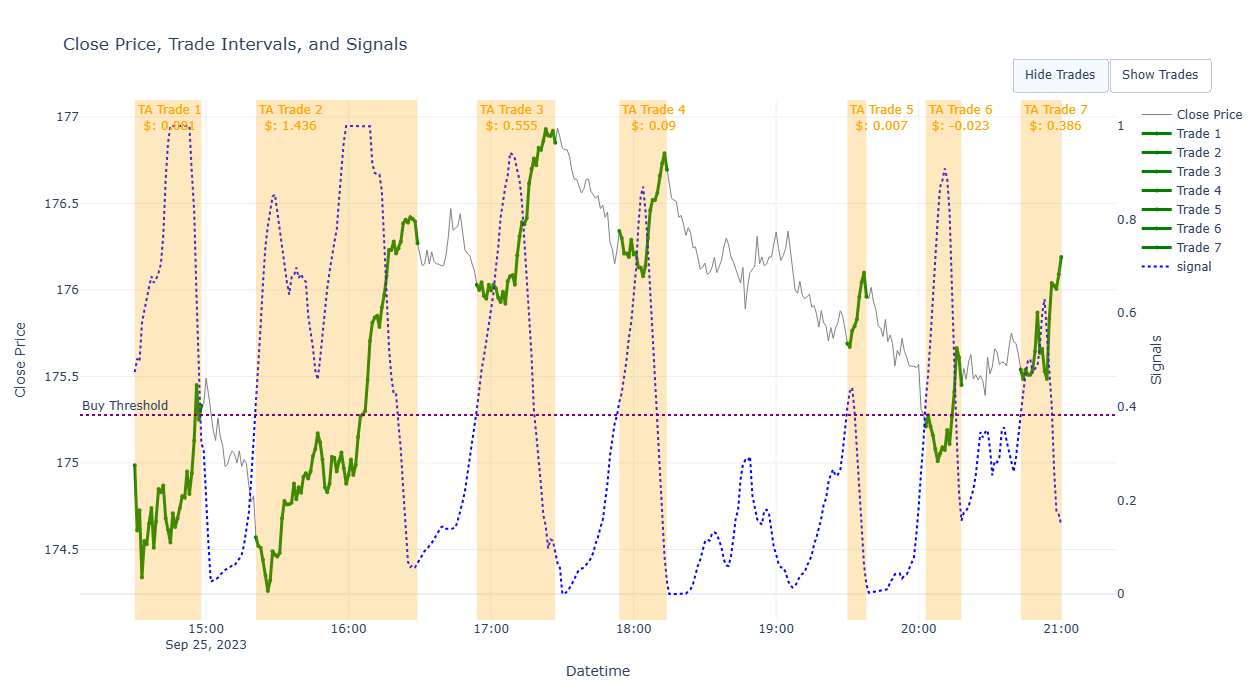


* Performance for 2023-09-25 *
  Buy & Hold Return ($): 0.94
  Strategy Return ($): 2.532
  Trades Returns ($): [0.081, 1.436, 0.555, 0.09, 0.007, -0.023, 0.386]

=== Processing trading day 2023-09-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


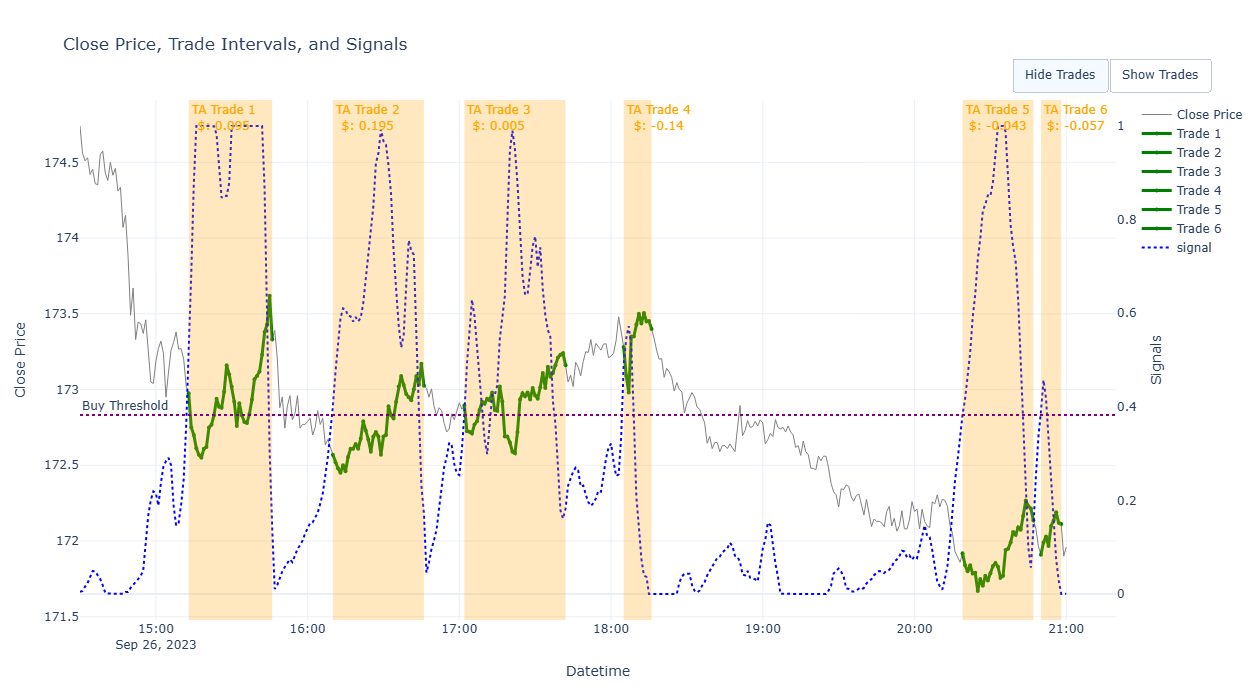


* Performance for 2023-09-26 *
  Buy & Hold Return ($): -3.04
  Strategy Return ($): 0.057
  Trades Returns ($): [0.095, 0.195, 0.005, -0.14, -0.043, -0.057]

=== Processing trading day 2023-09-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


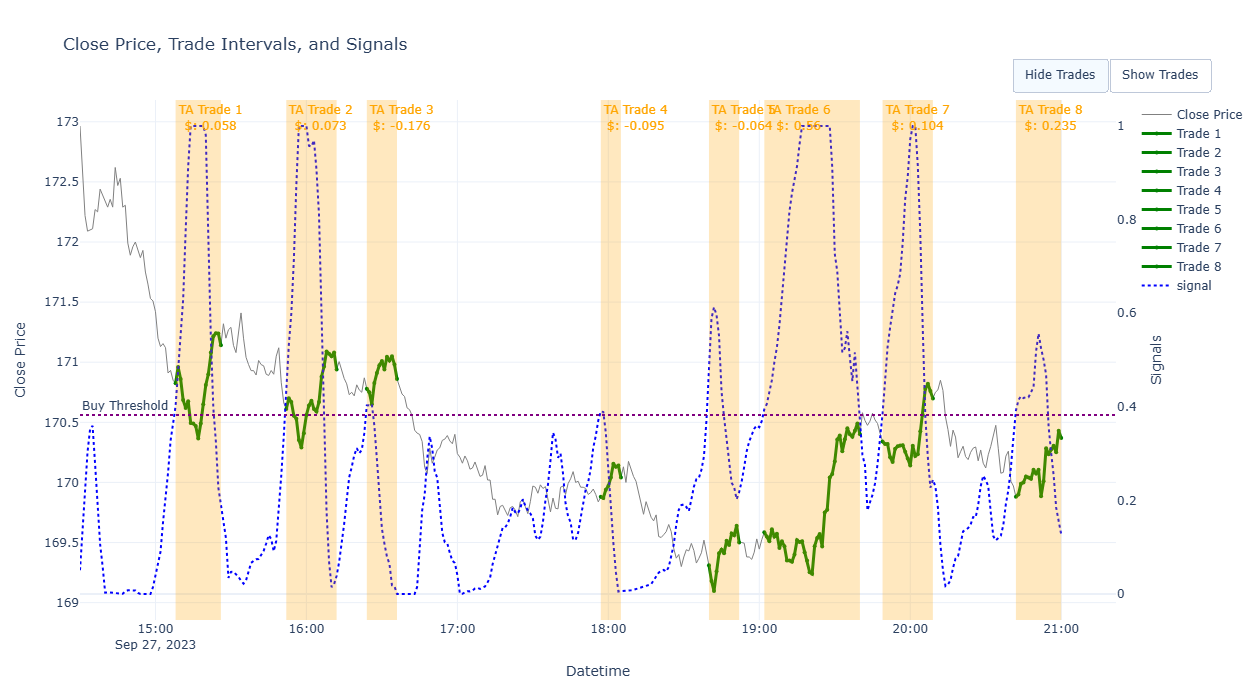


* Performance for 2023-09-27 *
  Buy & Hold Return ($): -2.852
  Strategy Return ($): 0.695
  Trades Returns ($): [0.058, 0.073, -0.176, -0.095, -0.064, 0.56, 0.104, 0.235]

=== Processing trading day 2023-09-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


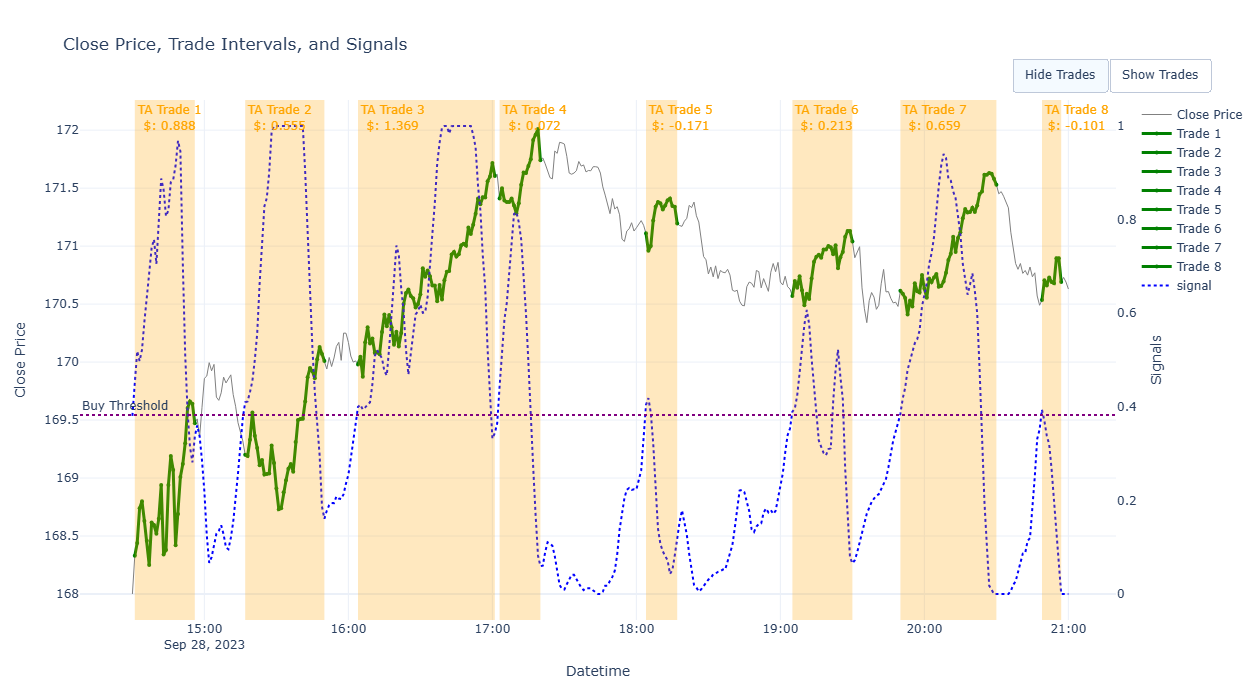


* Performance for 2023-09-28 *
  Buy & Hold Return ($): 2.376
  Strategy Return ($): 3.486
  Trades Returns ($): [0.888, 0.555, 1.369, 0.072, -0.171, 0.213, 0.659, -0.101]

=== Processing trading day 2023-09-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


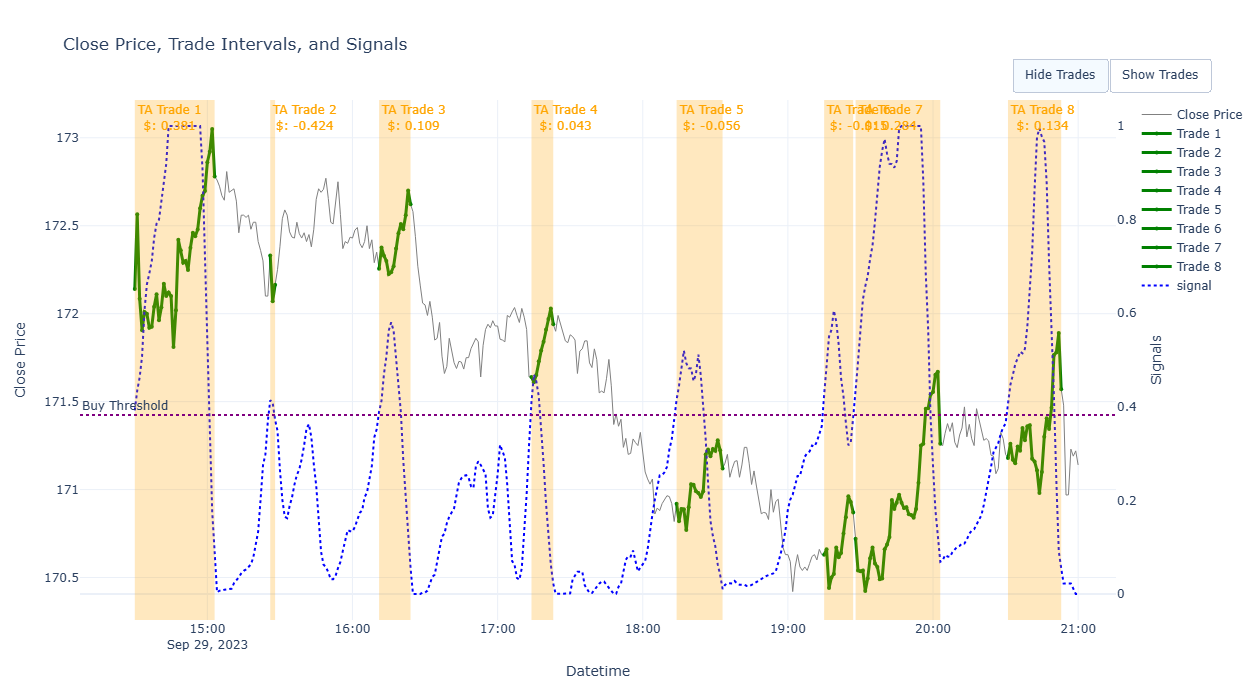


* Performance for 2023-09-29 *
  Buy & Hold Return ($): -1.258
  Strategy Return ($): 0.451
  Trades Returns ($): [0.381, -0.424, 0.109, 0.043, -0.056, -0.015, 0.284, 0.134]

Overall Summary (2023-09-01 = 189.7672 → 2023-09-29 = 171.0116)

One-time buy&hold gain: -18.756
Buy & Hold – each day ($): -17.057
Strategy Return ($): 26.403
Trades Count: 132
Strategy return per trade: 0.200
Num. trading days: 20
Strategy return per trading day: 1.320


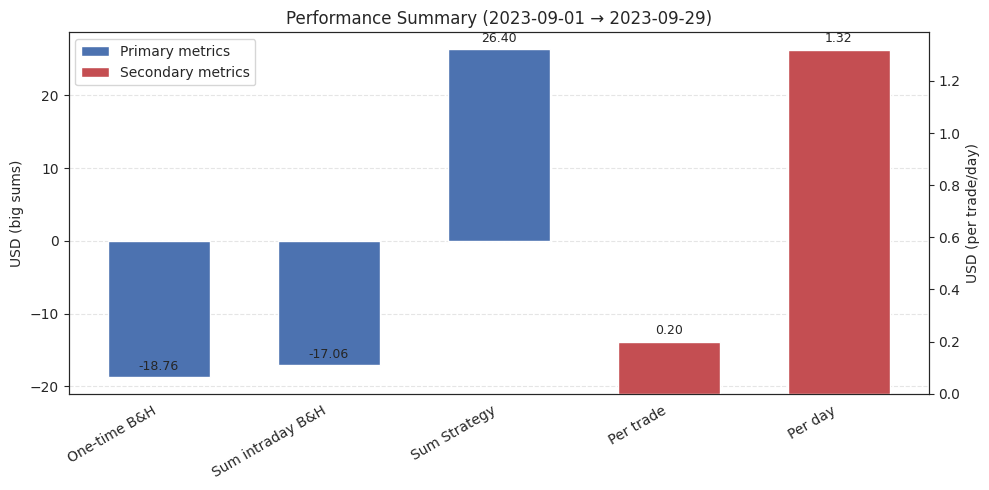


Full‐run mode
• Running trading pipeline on full dataset …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:43<00:00, 32.98day/s]



Full‐period performance:

Overall Summary (2004-01-02 = 0.7731 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 195.620
Buy & Hold – each day ($): -385.278
Strategy Return ($): 3077.638
Trades Count: 31138
Strategy return per trade: 0.099
Num. trading days: 5400
Strategy return per trading day: 0.570


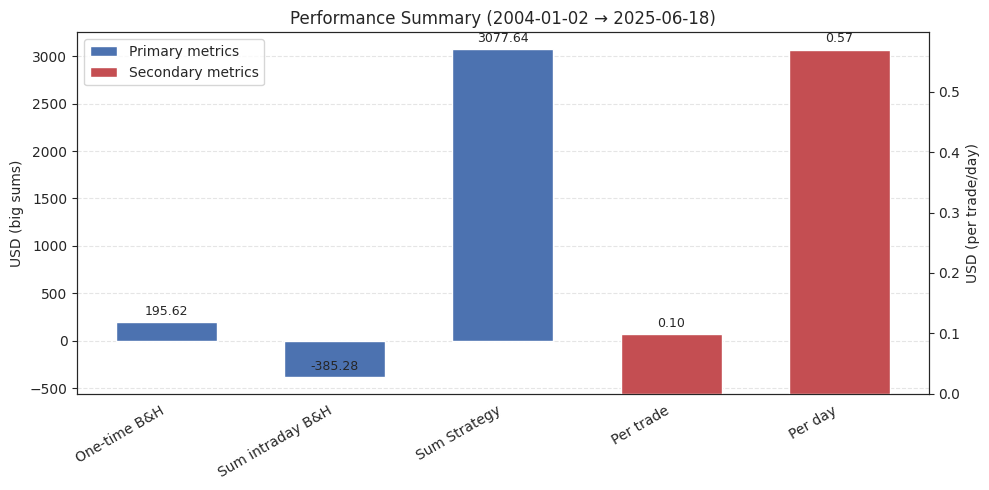


Test‐period performance:

Overall Summary (2022-03-28 = 172.8295 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 23.563
Buy & Hold – each day ($): -189.487
Strategy Return ($): 1526.729
Trades Count: 4581
Strategy return per trade: 0.333
Num. trading days: 810
Strategy return per trading day: 1.885


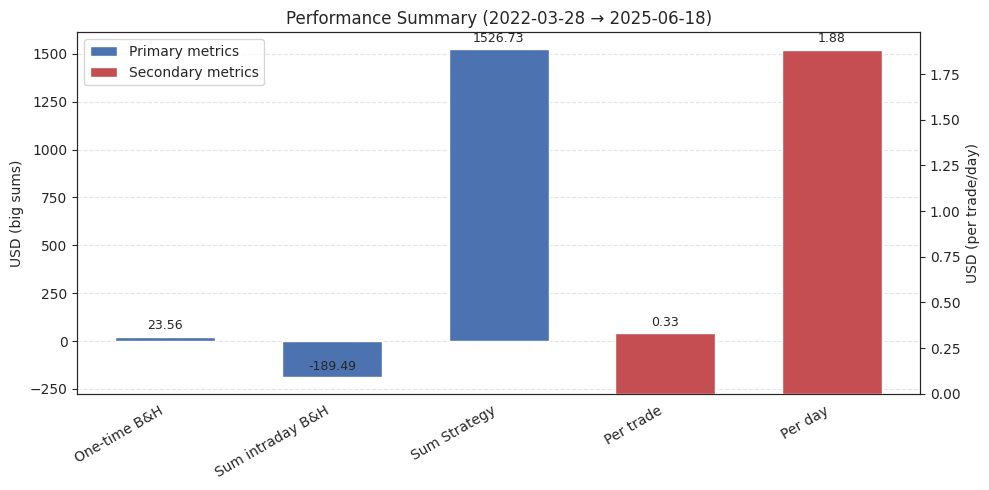


• Saving signals CSV …
Saved to dfs_training/AAPL_2_sign.csv


open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         bid         ask  StrategyEarning  \
2004-01-02 09:00:00     28000.0    0.763714    0.764857            0.000   
2004-01-02 09:01:00     28000.0    0.763714    0.764857            0.000   
2004-01-02 09:02:00     28000.0    0.763714    0.764857            0.000   
2004-01-02 09:03:00     28000.0    0.763714    0.764857            0.000   
2004-01-02 09:04:00     28000.0    0.763714    0.764857            0.000   
...                         ...         ...         ...              ...   
2025-06-18 20:56:00    385695.0  196.667400  196.962600            2.967   
2025-06-18 20:57:00    460630.0  196.527500  196.822500            2.827   
2025-06-18 20:58:00    525245.0  196.522500  196.817500            2.827   
2025-06-18 20:59:00   2075503.0  196.092800  196.387200            2.827   
2025-06-18 21:00:00  15600625.0  196.392600  196.687400            2.827   

                     EarningDiff        signal  signal_action  
2004-01-02 09:00:00        0.000  1.654738e-08              0  
2004-01-02 09:01:00        0.000  1.706997e-08              0  
2004-01-02 09:02:00        0.000  1.761434e-08              0  
2004-01-02 09:03:00        0.000  1.870507e-08              0  
2004-01-02 09:04:00        0.000  1.986335e-08              0  
...                          ...           ...            ...  
2025-06-18 20:56:00        2.367  1.858896e-01              0  
2025-06-18 20:57:00        2.366  5.683793e-02             -1  
2025-06-18 20:58:00        2.371  4.687768e-04              0  
2025-06-18 20:59:00        2.801  5.859710e-04              0  
2025-06-18 21:00:00        2.501  7.812946e-04              0  

[3893400 rows x 11 columns]

In [5]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

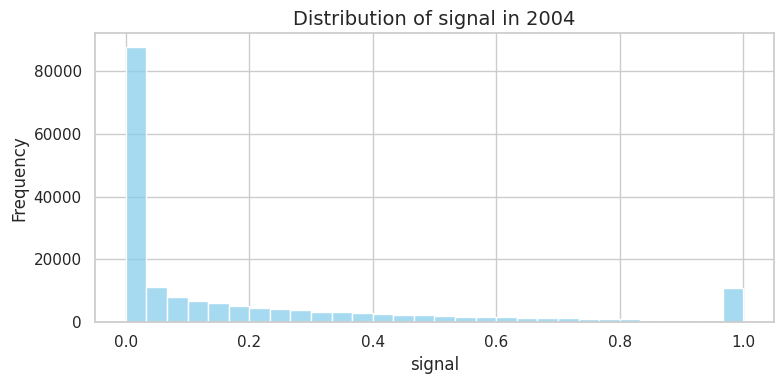

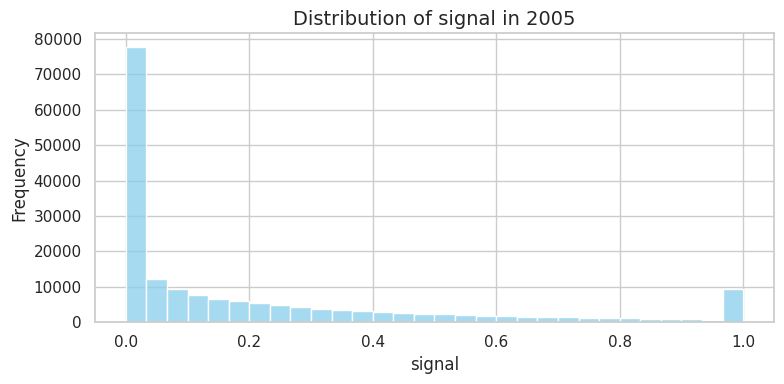

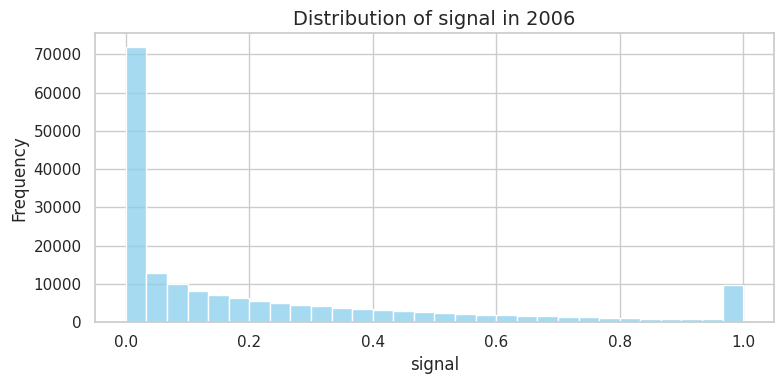

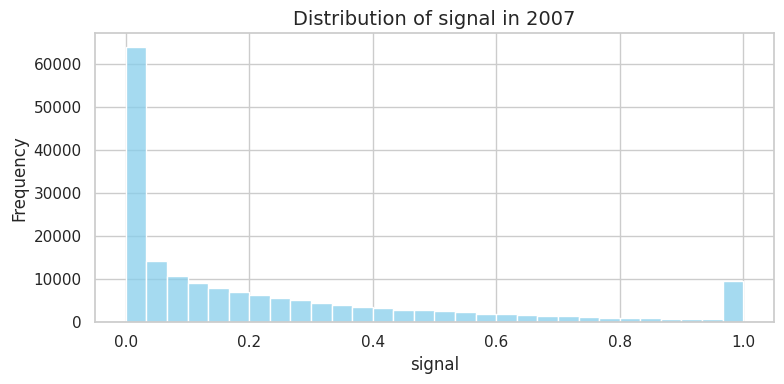

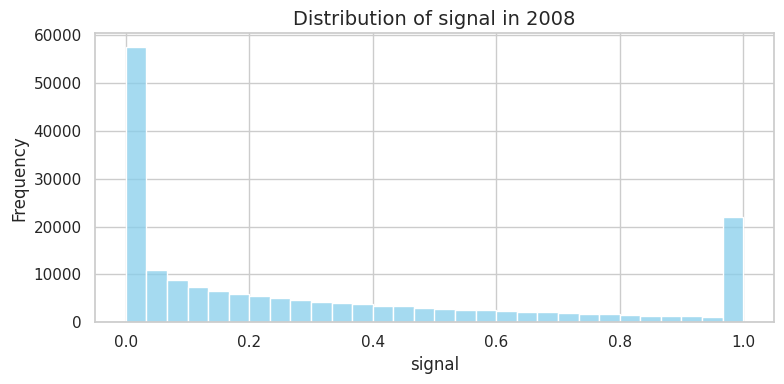

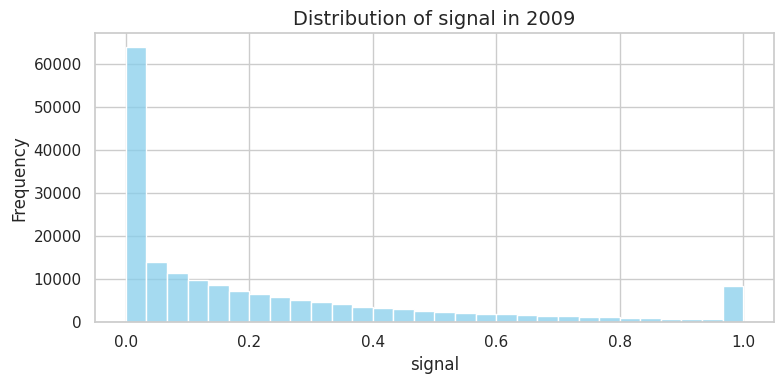

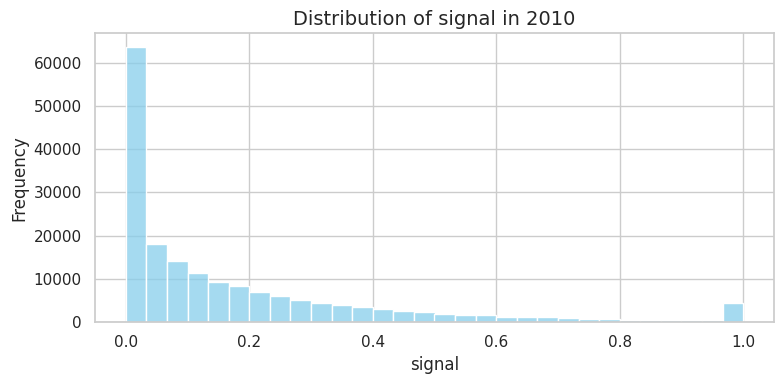

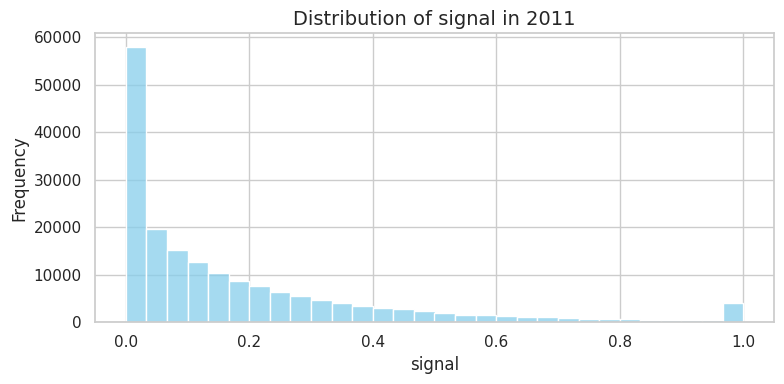

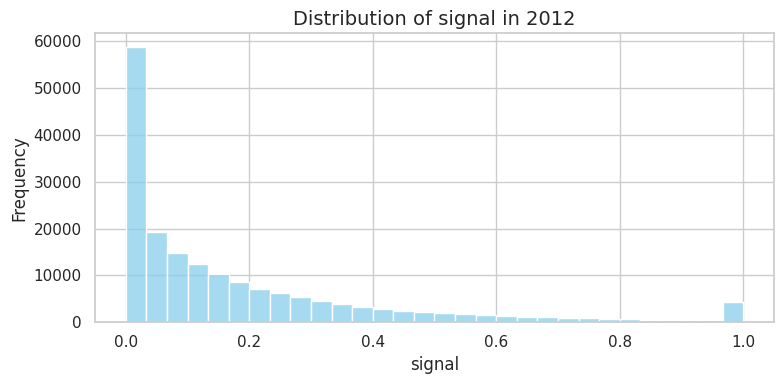

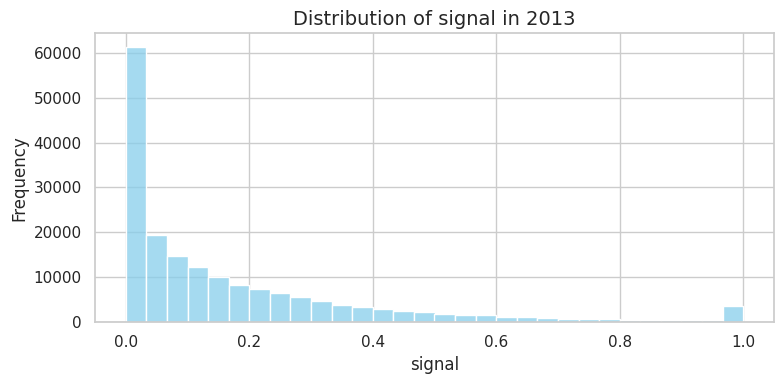

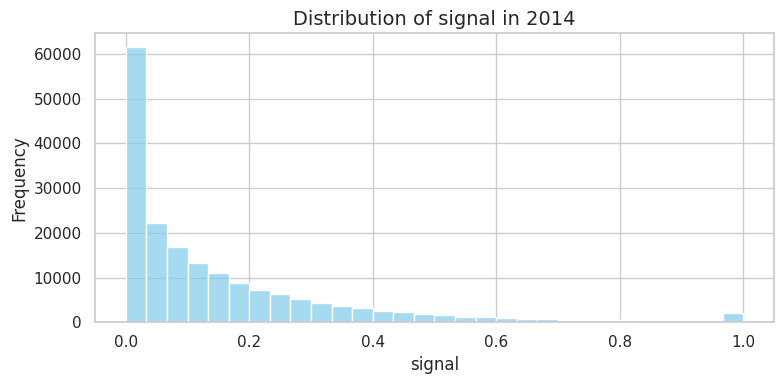

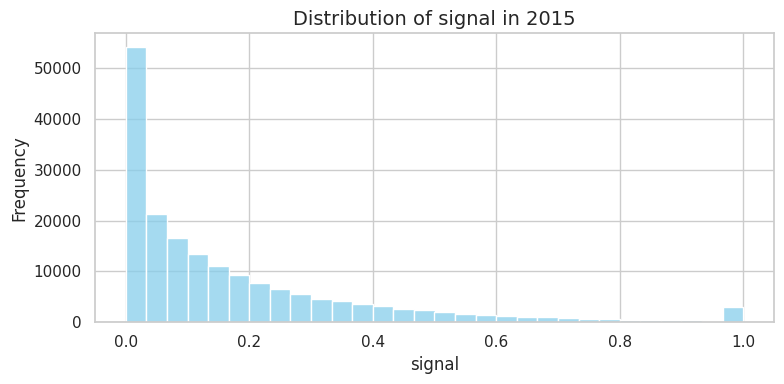

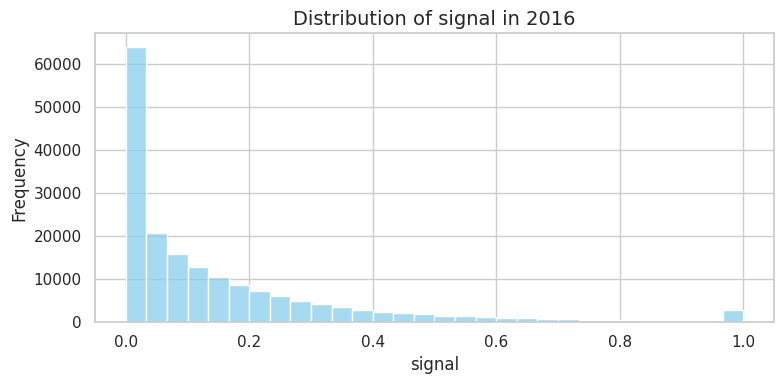

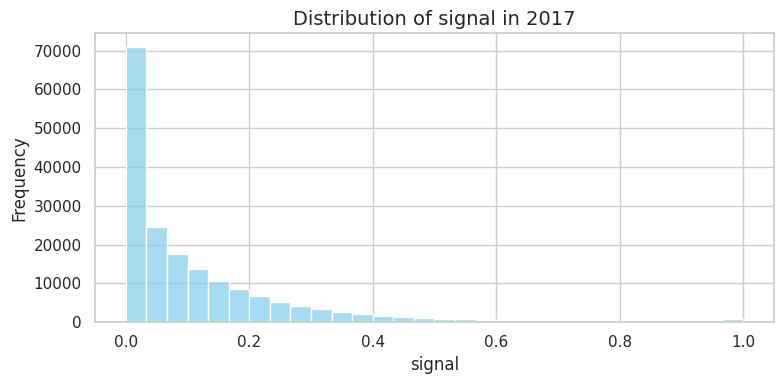

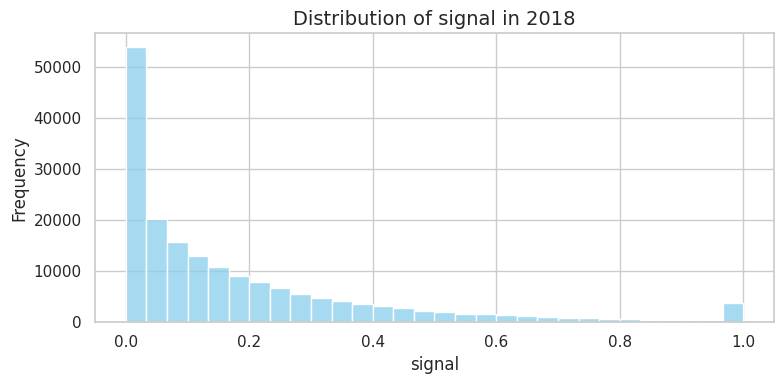

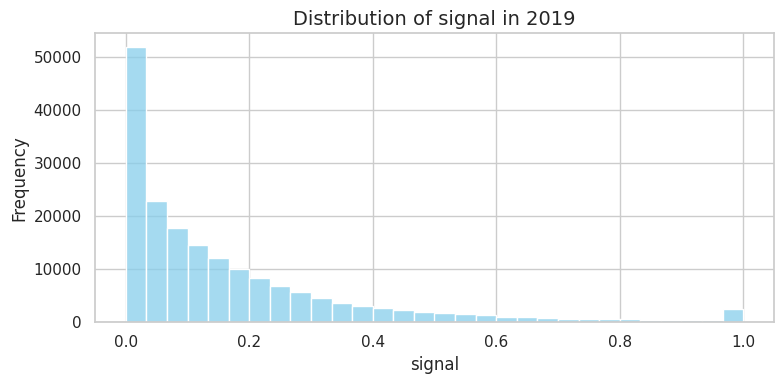

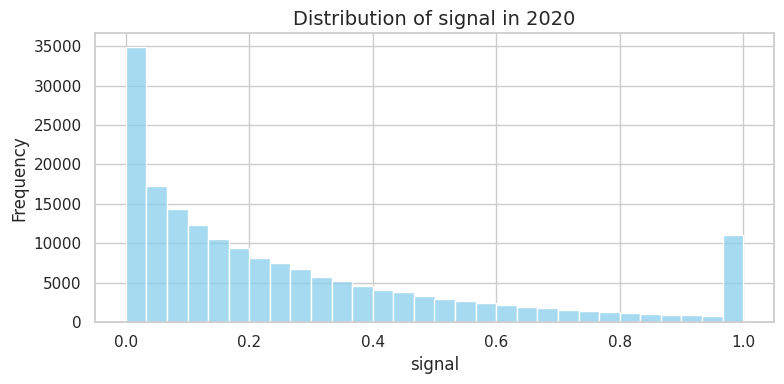

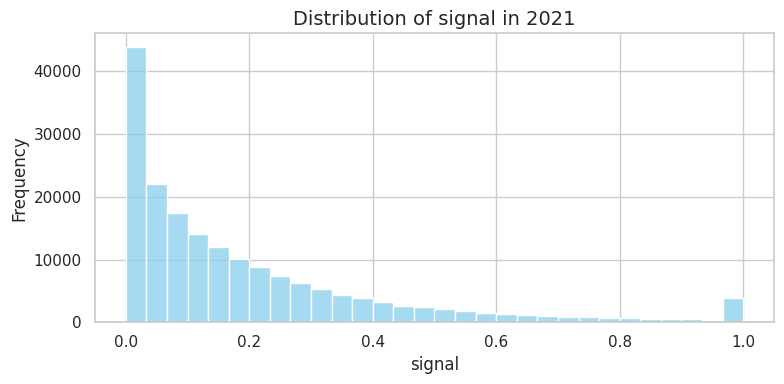

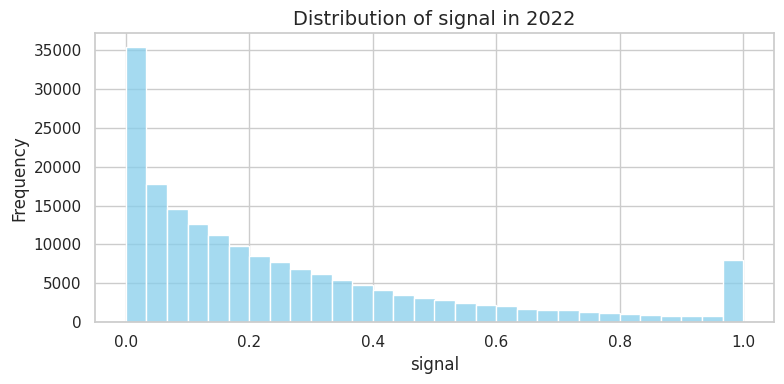

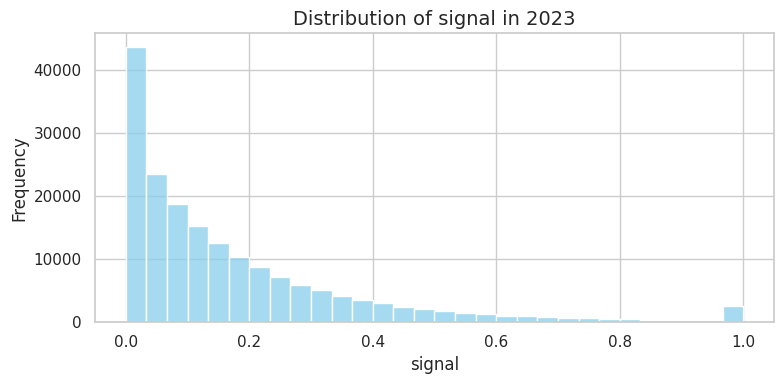

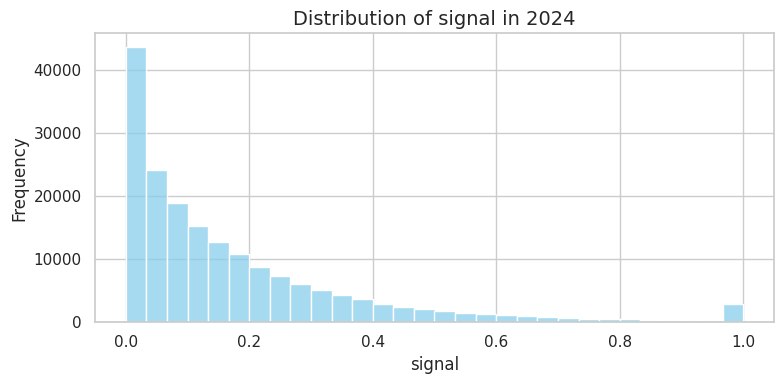

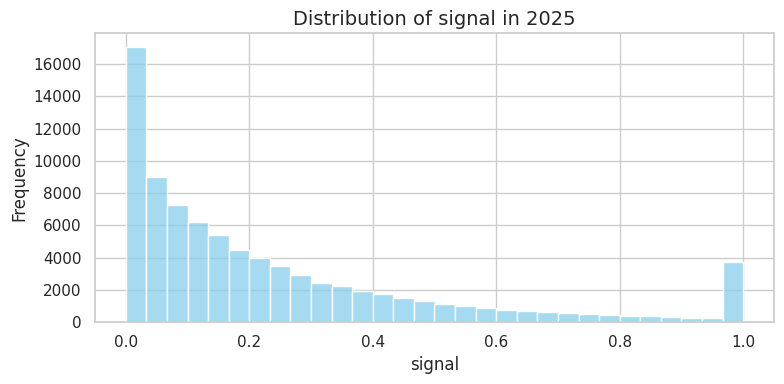

signal_min  signal_max  signal_mean  signal_median  close_return
2004-01         0.0    1.000000     0.208553       0.044780      0.170916
2004-02         0.0    1.000000     0.167592       0.025769      0.105893
2004-03         0.0    1.000000     0.211097       0.040866      0.196335
2004-04         0.0    1.000000     0.197015       0.029410      0.156863
2004-05         0.0    1.000000     0.205342       0.032709      0.127743
2004-06         0.0    1.000000     0.198743       0.042332      0.241579
2004-07         0.0    1.000000     0.204573       0.040743      0.161862
2004-08         0.0    1.000000     0.200814       0.031164      0.182185
2004-09         0.0    1.000000     0.189017       0.038130      0.145439
2004-10         0.0    1.000000     0.214062       0.058241      0.409440
2004-11         0.0    1.000000     0.212043       0.056572      0.333589
2004-12         0.0    1.000000     0.189952       0.063088      0.101071
2005-01         0.0    1.000000     0.232965       0.082372      0.243334
2005-02         0.0    1.000000     0.227424       0.085300      1.067515
2005-03         0.0    1.000000     0.211959       0.066128      0.160576
2005-04         0.0    1.000000     0.248495       0.079988      0.295820
2005-05         0.0    1.000000     0.219604       0.074464      0.234620
2005-06         0.0    1.000000     0.182571       0.049915      0.145751
2005-07         0.0    1.000000     0.192268       0.067730      0.222039
2005-08         0.0    1.000000     0.174517       0.045865      0.143297
2005-09         0.0    1.000000     0.195029       0.059728      0.183041
2005-10         0.0    1.000000     0.260758       0.103633      0.240634
2005-11         0.0    1.000000     0.207042       0.068836      0.246400
2005-12         0.0    1.000000     0.183233       0.072189      0.117481
2006-01         0.0    1.000000     0.270309       0.120984      0.216178
2006-02         0.0    1.000000     0.254766       0.102852      0.213435
2006-03         0.0    1.000000     0.226033       0.081174      0.212021
2006-04         0.0    1.000000     0.229475       0.082333      0.186985
2006-05         0.0    1.000000     0.201821       0.073175      0.247914
2006-06         0.0    1.000000     0.224021       0.078105      0.137473
2006-07         0.0    1.000000     0.239013       0.092610      0.358532
2006-08         0.0    1.000000     0.228521       0.094242      0.123615
2006-09         0.0    1.000000     0.216821       0.099713      0.150496
2006-10         0.0    1.000000     0.172454       0.064257      0.136044
2006-11         0.0    1.000000     0.187502       0.074444      0.205850
2006-12         0.0    1.000000     0.198762       0.071843      0.199142
2007-01         0.0    1.000000     0.231062       0.113548      0.192073
2007-02         0.0    1.000000     0.167944       0.069068      0.094767
2007-03         0.0    1.000000     0.169858       0.069572      0.156511
2007-04         0.0    1.000000     0.164809       0.064565      0.167337
2007-05         0.0    1.000000     0.193923       0.089111      0.238485
2007-06         0.0    1.000000     0.216952       0.109149      0.102931
2007-07         0.0    1.000000     0.239246       0.115423      0.245818
2007-08         0.0    1.000000     0.291061       0.152790      0.247318
2007-09         0.0    1.000000     0.240885       0.121674      0.193898
2007-10         0.0    1.000000     0.235746       0.116792      0.244270
2007-11         0.0    1.000000     0.323119       0.171597      0.274720
2007-12         0.0    1.000000     0.237171       0.117352      0.151206
2008-01         0.0    1.000000     0.340436       0.192660      0.585735
2008-02         0.0    1.000000     0.284036       0.157236      0.188922
2008-03         0.0    1.000000     0.316804       0.166901      0.233486
2008-04         0.0    1.000000     0.270634       0.159639      0.240805
2008-05         0.0    1.000000     0.227197       0.122215      0.112945
2008-06      

In [6]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
